In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from sklearn import svm
import datetime as dt
from sklearn.ensemble import RandomForestClassifier 

In [2]:
df = pd.read_csv("./match_data_yearly/all_years.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index(df["Date"])

In [3]:
df

,ID,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances,HomeElo,AwayElo,HomeED,AwayED
Date,,,,,,,,,,,,,,,,,
2006-03-04,6010903,2006,1,2006-03-04,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916,1500,1500,0,0
2006-03-05,6012807,2006,1,2006-03-05,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277,1500,1500,0,0
2006-03-05,6012231,2006,1,2006-03-05,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531,1500,1500,0,0
2006-03-05,6011323,2006,1,2006-03-05,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564,1500,1500,0,0
2006-03-05,6010820,2006,1,2006-03-05,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199,1500,1500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-19,20340120,2020,34,2020-12-19,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251,1594,1560,4,-6
2020-12-19,20340810,2020,34,2020-12-19,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825,1515,1524,9,-13
2020-12-19,20343331,2020,34,2020-12-19,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966,1453,1458,17,7


In [4]:
accuracies = []
calibrations = []

for _ in range(10):
    for year in (2013,2014,2015,2016,2017,2018,2019,2020):

        df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
        X_train=df_past[["HomeElo","AwayElo","HomeED","AwayED"]].values
        y_train = df_past["W/L"].values

        df_future = df[f"{year}"]
        X_test = df_future[["HomeElo","AwayElo","HomeED","AwayED"]].values
        y_test = df_future["W/L"].values


        rf= RandomForestClassifier(max_depth=6)  
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_test)
        y_pred_proba=rf.predict_proba(X_test)

        accuracy = rf.score(X_test,y_test) 
        accuracies.append(accuracy)


        count=0

        pred_winrate_sum=0 # 予測勝率の和
        actual_win_sum=0 # 実勝利数の和

        pred_drawrate_sum=0 # 予測引き分け率の和
        actual_draw_sum=0 # 実引き分け数の和

        pred_lossrate_sum=0 # 予測敗率の和
        actual_loss_sum=0 # 実敗北数の和

        for index,row in df_future.iterrows():
            # ホームが実力上位
            if row["HomeElo"] > row["AwayElo"]: 
                pred_winrate_sum += y_pred_proba[count][1] 
                pred_drawrate_sum += y_pred_proba[count][0]
                pred_lossrate_sum += y_pred_proba[count][2]

                if y_test[count] == 1: 
                    actual_win_sum += 1
                elif y_test[count] == 0:
                    actual_draw_sum += 1
                else:
                    actual_loss_sum += 1

            # アウェイが実力上位
            elif row["AwayElo"] > row["HomeElo"]: 
                pred_winrate_sum += y_pred_proba[count][2] 
                pred_drawrate_sum += y_pred_proba[count][0]
                pred_lossrate_sum += y_pred_proba[count][1]

                if y_test[count] == 2:
                    actual_win_sum += 1
                elif y_test[count] == 0:
                    actual_draw_sum += 1
                else:
                    actual_loss_sum += 1

            count+= 1

        
        # 10ループ目の予測をpredict_probaをtoto予想に使用
#         df_y_pred_proba=pd.DataFrame(y_pred_proba)
#         df_y_pred_proba.insert(0,"MatchID",df_future["ID"].values)
#         df_y_pred_proba.to_csv(f"./predict_proba_data/{year}.csv", index=False)
        
        calibration = pred_winrate_sum/actual_win_sum
        calibrations.append(calibration)
#         print(f"{year} : {pred_winrate_sum/actual_win_sum :.2f} {pred_drawrate_sum/actual_draw_sum :.2f} {pred_lossrate_sum/actual_loss_sum :.2f}   {accuracy:.2f}")

        
# 8シーズン×10回の精度の平均
print("2013~2020の8シーズンを10回分予測")
print(f"的中率の平均値 : {np.mean(accuracies):.3f}  較正値の平均値 : {np.mean(calibrations):.3f}")

2013~2020の8シーズンを10回分予測
的中率の平均値 : 0.463  較正値の平均値 : 0.979


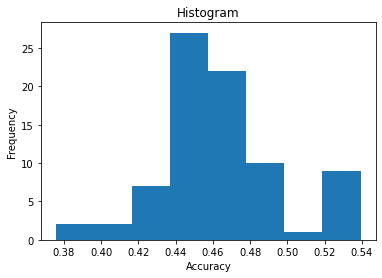

In [5]:
n, bins, patches=plt.hist(accuracies, bins=8)
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

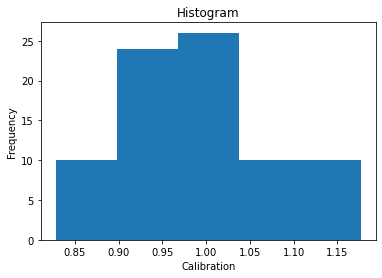

In [6]:
n, bins, patches=plt.hist(calibrations, bins=5)
plt.xlabel("Calibration")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [7]:
calibrations

[0.9168301411537345,
 0.9770508730498595,
 0.940312855084146,
 0.975345957231799,
 1.0438933383090576,
 1.1764289267935157,
 0.969548588651471,
 0.83095389445824,
 0.919016524266861,
 0.9811884083365803,
 0.9404733309694315,
 0.9834452722002278,
 1.045813775305291,
 1.163691326357713,
 0.9709467702985606,
 0.8375972719903257,
 0.9152202504416416,
 0.9868249558878421,
 0.931291696145094,
 0.9658204091710401,
 1.0427507409730967,
 1.1643156386177633,
 0.9696110086707346,
 0.8324468417185713,
 0.9196977810178225,
 0.9892608402282034,
 0.9312248675641006,
 0.9735749542524232,
 1.0474758061620357,
 1.171604677504133,
 0.9642658620173743,
 0.8322274474535429,
 0.9183433420785118,
 0.9975197338550474,
 0.9358629753294605,
 0.9887087988420203,
 1.0493447627519676,
 1.16770856724761,
 0.9610462831360972,
 0.8384824637403764,
 0.9167356234554341,
 0.9861756897116292,
 0.9291801387611315,
 0.9824040973330779,
 1.0483912434766913,
 1.159035588473373,
 0.9699259896687296,
 0.8291941007243802,
 0.91

### 考察

以前まで外部サイトから取得していたeloratingとは違い今回は自分で算出したところ､精度が大きく下がった｡以前までの所得方法に誤りがあった可能性がある｡
また､今後の拡張性も考慮して自分で算出したratingを用いる｡

rating値しか使っていないので､ratingの大小で分類されやすく分類の精度が伸びていないのでは?と考えられる

較正値での検証では､ (予測勝率の和)/(実際の勝利数)が0を下回るため､予測モデルが過小評価している傾向にあることも分かる｡
ただ､引き分けをほとんど予測しないモデルだが､較正値で検証すると､引き分けを程よく判断できているとも取れる｡

In [8]:
accuracies = []
calibrations = []

# BEGIN

In [9]:
year = 2020

df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
X_train=df_past[["HomeElo","AwayElo"]].values
y_train = df_past["W/L"].values

df_future = df[f"{year}"]
X_test = df_future[["HomeElo","AwayElo"]].values
y_test = df_future["W/L"].values


rf= RandomForestClassifier(max_depth=5)  
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
y_pred_proba=rf.predict_proba(X_test)

accuracy = rf.score(X_test,y_test) 
accuracies.append(accuracy)


count=0
pred_winrate_sum=0 # 予測勝率の和
actual_winrate_sum=0 # 実勝率の和

for index,row in df_future.iterrows():
    if row["HomeElo"] > row["AwayElo"]: # ホームが実力上位
        pred_winrate_sum += y_pred_proba[count][1] # ホームの予想勝率を加算
        if y_test[count] == 1: # 実際にホームが勝ったならば､1を加算
            actual_winrate_sum += 1
    elif row["AwayElo"] > row["HomeElo"]: # アウェイが実力上位
        pred_winrate_sum += y_pred_proba[count][2] # アウェイの予想勝率を加算
        if y_test[count] == 2: # 実際にアウェイが勝ったならば､1を加算
             actual_winrate_sum += 1 

    count+= 1

calibration = pred_winrate_sum/actual_winrate_sum
calibrations.append(calibration)

In [10]:
rf.feature_importances_

array([0.47069223, 0.52930777])

<AxesSubplot:>

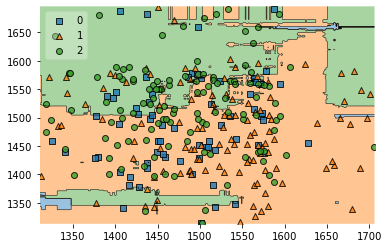

In [18]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=X_test, y=y_test, clf=rf, legend=2)

<AxesSubplot:>

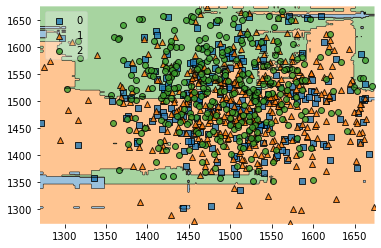

In [19]:
plot_decision_regions(X=X_train, y=y_train, clf=rf, legend=2)

In [20]:
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.528322440087146, 0.434640522875817)

In [21]:
pd.value_counts(y_train), pd.value_counts(y_test)

(1    382
 2    322
 0    214
 dtype: int64,
 2    120
 1    118
 0     68
 dtype: int64)

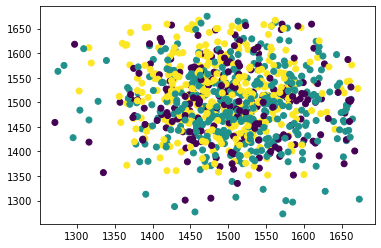

In [22]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

# ---

In [23]:
X_train=df_past[["HomeElo","AwayElo","HomeED","AwayED"]].values
y_train = df_past["W/L"].values

from sklearn.manifold import TSNE

tsne = TSNE(random_state=1234)
X_embedded = tsne.fit_transform(X_train)

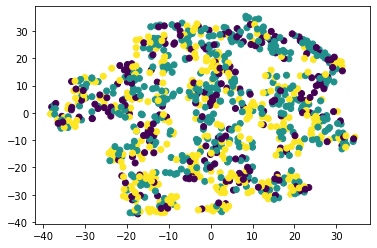

In [24]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train)

# END

In [25]:
year = 2020

df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
X_train=df_past[["HomeElo","AwayElo","HomeED","AwayED"]].values
y_train = df_past["W/L"].values

df_future = df[f"{year}"]
X_test = df_future[["HomeElo","AwayElo","HomeED","AwayED"]].values
y_test = df_future["W/L"].values


rf= RandomForestClassifier(max_depth=5)  
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
y_pred_proba=rf.predict_proba(X_test)

accuracy = rf.score(X_test,y_test) 
accuracies.append(accuracy)


count=0
pred_winrate_sum=0 # 予測勝率の和
actual_winrate_sum=0 # 実勝率の和

for index,row in df_future.iterrows():
    if row["HomeElo"] > row["AwayElo"]: # ホームが実力上位
        pred_winrate_sum += y_pred_proba[count][1] # ホームの予想勝率を加算
        if y_test[count] == 1: # 実際にホームが勝ったならば､1を加算
            actual_winrate_sum += 1
    elif row["AwayElo"] > row["HomeElo"]: # アウェイが実力上位
        pred_winrate_sum += y_pred_proba[count][2] # アウェイの予想勝率を加算
        if y_test[count] == 2: # 実際にアウェイが勝ったならば､1を加算
             actual_winrate_sum += 1 

    count+= 1

calibration = pred_winrate_sum/actual_winrate_sum
calibrations.append(calibration)

In [26]:
rf.feature_importances_

array([0.2750419 , 0.31518725, 0.22573993, 0.18403092])

In [27]:
# 2010~2020の試合の"W/L"の各回数
df["W/L"].value_counts()

1    1936
2    1576
0    1078
Name: W/L, dtype: int64

In [28]:
# 予測したy_predの0,1,2の各出現回数
print("予測")
print(pd.Series(y_pred).value_counts())
print("======")
print("実際")
# 実際のy_testの0,1,2の各出現回数
print(pd.Series(y_test).value_counts())

予測
1    190
2    113
0      3
dtype: int64
実際
2    120
1    118
0     68
dtype: int64


1(ホーム勝利)に分類しまくってしまっている｡ 0(引き分け)を1と分類してしまっているともとれる??

0と1と2の大小関係的に､1が真ん中で分類されやすい可能性あり 
→ 0(ホーム勝利),1(引き分け),2(ホーム敗北)でやってみたが､効果なし｡

単純に過去の試合からホームのほうが勝率が高い傾向にあるので､それが影響しているだけかな?

In [29]:
# y_pred_proba=rf.predict_proba(X_test)
# y_pred_proba # [引き分け, ホーム勝ち, アウェイ勝ち]

In [30]:
y_pred

array([1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1,
       2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1,
       2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2,
       2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2,

In [31]:
count=0
pred_winrate_sum=0 # 予測勝率の和
actual_winrate_sum=0 # 実勝率の和

for index,row in df_future.iterrows():
    if row["HomeElo"] > row["AwayElo"]: # ホームが実力上位
        pred_winrate_sum += y_pred_proba[count][1] # ホームの予想勝率を加算
        if y_test[count] == 1: # 実際にホームが勝ったならば､1を加算
            actual_winrate_sum += 1
    elif row["AwayElo"] > row["HomeElo"]: # アウェイが実力上位
        pred_winrate_sum += y_pred_proba[count][2] # アウェイの予想勝率を加算
        if y_test[count] == 2: # 実際にアウェイが勝ったならば､1を加算
             actual_winrate_sum += 1 
    
    count+= 1

In [32]:
pred_winrate_sum

132.87717384245028

In [33]:
actual_winrate_sum

161

In [34]:
# 較正値(予測勝率と実勝率との比)
pred_winrate_sum/actual_winrate_sum 

0.8253240611332315

### 考察

較正値で評価すると､概ね1±0.2あたりに収まることから､eloratingで勝率を予測できることが分かる｡
改善の余地もまだまだある

In [35]:
match_id_list = df_future["ID"].values
match_result_list = df_future["W/L"].values

### アンダーサンプリングしてみる

In [104]:
from imblearn.under_sampling import RandomUnderSampler 

In [178]:
year = 2020

df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
X_train=df_past[["HomeElo","AwayElo","HomeED","AwayED"]].values
y_train = df_past["W/L"].values

df_future = df[f"{year}"]
X_test = df_future[["HomeElo","AwayElo","HomeED","AwayED"]].values
y_test = df_future["W/L"].values



In [179]:
rus = RandomUnderSampler(sampling_strategy={1:120, 2:120, 0:60}, random_state=1234)

In [180]:
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [181]:
rf= RandomForestClassifier(max_depth=5)  
rf.fit(X_train_rus,y_train_rus)
y_pred = rf.predict(X_test)
y_pred_proba=rf.predict_proba(X_test)

In [182]:
accuracy = rf.score(X_test,y_test) 
accuracy

0.4542483660130719

In [183]:
pd.DataFrame({'pred':y_pred,'actual':y_test})

,pred,actual
0,2,2
1,1,0
2,1,1
3,1,1
4,1,0
...,...,...
301,1,0
302,1,1
303,1,0
304,1,1


In [184]:
pd.Series(y_pred).value_counts()

1    166
2    137
0      3
dtype: int64

In [185]:
rf.feature_importances_

array([0.25860692, 0.31109506, 0.2374398 , 0.19285822])

In [186]:
accuracies = []
calibrations = []

for _ in range(10):
    for year in (2013,2014,2015,2016,2017,2018,2019,2020):

        df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
        X_train=df_past[["HomeElo","AwayElo","HomeED","AwayED"]].values
        y_train = df_past["W/L"].values

        df_future = df[f"{year}"]
        X_test = df_future[["HomeElo","AwayElo","HomeED","AwayED"]].values
        y_test = df_future["W/L"].values
        
        rus = RandomUnderSampler(sampling_strategy={0:60, 1:120, 2:120},random_state=1234)
        X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
        

        rf= RandomForestClassifier(max_depth=6)  
        rf.fit(X_train_rus,y_train_rus)
        y_pred = rf.predict(X_test)
        y_pred_proba=rf.predict_proba(X_test)

        accuracy = rf.score(X_test,y_test) 
        accuracies.append(accuracy)
        
#         print(pd.Series(y_pred).value_counts())


        count=0

        pred_winrate_sum=0 # 予測勝率の和
        actual_win_sum=0 # 実勝利数の和

        pred_drawrate_sum=0 # 予測引き分け率の和
        actual_draw_sum=0 # 実引き分け数の和

        pred_lossrate_sum=0 # 予測敗率の和
        actual_loss_sum=0 # 実敗北数の和

        for index,row in df_future.iterrows():
            # ホームが実力上位
            if row["HomeElo"] > row["AwayElo"]: 
                pred_winrate_sum += y_pred_proba[count][1] 
                pred_drawrate_sum += y_pred_proba[count][0]
                pred_lossrate_sum += y_pred_proba[count][2]

                if y_test[count] == 1: 
                    actual_win_sum += 1
                elif y_test[count] == 0:
                    actual_draw_sum += 1
                else:
                    actual_loss_sum += 1

            # アウェイが実力上位
            elif row["AwayElo"] > row["HomeElo"]: 
                pred_winrate_sum += y_pred_proba[count][2] 
                pred_drawrate_sum += y_pred_proba[count][0]
                pred_lossrate_sum += y_pred_proba[count][1]

                if y_test[count] == 2:
                    actual_win_sum += 1
                elif y_test[count] == 0:
                    actual_draw_sum += 1
                else:
                    actual_loss_sum += 1

            count+= 1

        
        # 10ループ目の予測をpredict_probaをtoto予想に使用
#         df_y_pred_proba=pd.DataFrame(y_pred_proba)
#         df_y_pred_proba.insert(0,"MatchID",df_future["ID"].values)
#         df_y_pred_proba.to_csv(f"./predict_proba_data/{year}.csv", index=False)
        
        calibration = pred_winrate_sum/actual_win_sum
        calibrations.append(calibration)
#         print(f"{year} : {pred_winrate_sum/actual_win_sum :.2f} {pred_drawrate_sum/actual_draw_sum :.2f} {pred_lossrate_sum/actual_loss_sum :.2f}   {accuracy:.2f}")

        
# 8シーズン×10回の精度の平均
print("2013~2020の8シーズンを10回分予測")
print(f"的中率の平均値 : {np.mean(accuracies):.3f}  較正値の平均値 : {np.mean(calibrations):.3f}")

2013~2020の8シーズンを10回分予測
的中率の平均値 : 0.439  較正値の平均値 : 1.006


### 考察

アンダーサンプリングすることで的中率は全体的に下がる｡ 較正値に関しては大外れしていなく､toto予測の際はアンダーサンプリングで勝敗比を調整すれば､勝ち敗け分けの各確率の予測精度は､調整しないときよりよいかもしれない